# 视频检测 V3

使用说明：

这个是实时检测人脸

我储存了all_information，其中embedding是128。所有的检测都在一个function中。

Facenet 使用了 https://github.com/tamerthamoqa/facenet-pytorch-vggface2 提供的参数

In [9]:
#基本的引入，按字母表排序
import cv2
import json
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
from numpy import random
from numpy.random import uniform
import os
import PIL
from PIL import Image, ImageDraw
import random
from random import shuffle
import sys
sys.path.append(r'py')
import time
from tqdm import tqdm
#torch部分的import
import torch
import torchvision.transforms as transforms

## 导入MTCNN的model，以及FaceNet的model

In [10]:
from MTCNN_detector import MtcnnDetector,draw_face,vis_face

In [11]:
from models import P_Net,R_Net,O_Net,Resnet34Triplet

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
def load_net(save_folder, net_name):
    # pnet, rnet, onet = P_Net(), R_Net(), O_Net()
    net_list = {'pnet': P_Net(), 'rnet': R_Net(), 'onet': O_Net()}

    try:
        net = net_list[net_name].to(device)
        try:
            print('===> loading the saved net weights...')
            _ = os.path.join(save_folder, net_name + '.pkl')
            print('===> check {} saved path({}):{}'.format(net_name, _, os.path.exists(_)))
            net.load_state_dict(torch.load(_, map_location=device))
            return net  # , rnet, onet
        except Exception:            
            print('*** fail to load the saved net weights!')
            return net
    except Exception:
        print('*** Net name wrong!')

In [14]:
save_folder="CHUHR"
pnet= load_net(save_folder,'pnet')
rnet= load_net(save_folder,'rnet')
onet= load_net(save_folder,'onet')

===> loading the saved net weights...
===> check pnet saved path(CHUHR\pnet.pkl):True
===> loading the saved net weights...
===> check rnet saved path(CHUHR\rnet.pkl):True
===> loading the saved net weights...
===> check onet saved path(CHUHR\onet.pkl):True


## mtcnn_detector和facenet

In [15]:
mtcnn_detector = MtcnnDetector(pnet=pnet,rnet=rnet,onet=onet,min_face_size=12,threshold=[0.4,0.6,0.9])

In [16]:
checkpoint = torch.load('model_resnet34_triplet.pt',map_location=device)
model = Resnet34Triplet(embedding_dimension=checkpoint['embedding_dimension'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
best_distance_threshold = checkpoint['best_distance_threshold']

## 对实时摄像头的图片检测bbox和landmark，以及生成embedding信息

### 1.这些信息储存在json文件中，编码是'utf-8'

###  2.基本格式：
  
是一个视频产生一个list，list的每个元素代表当前帧的结果（如若视频有100帧，那json的list中就有100个元素）

如果当前帧没有检测到内容，则为None

如果当前帧检测到内容，放一个dictionary

dictionary的key有：

"image_name"：str image的名字

"image_path": str image的储存路径

"face_bbox"：list 每个元素是一个由五个数值组成的list： x1, y1, x2, y2, points

"face_embed"：list 每个元素是一个由num of embedding 组成的list

"face_landmark": [ (Lx1,Ly1,Lx2,Ly2,Lx3,Ly3,Lx4,Ly4,Lx5,Ly5) , () ,... ]

### 具体步骤

MTCNN detector 对输入的图片生成bounding box以及landmark。利用boundding box和landmark信息，我实现了人脸仿射。 把仿射的人脸输入到facenet当中生成embedding信息。最终把 "image_name" "image_path""face_bbox""face_embed""face_landmark"全部储存到json文件中。

## 利用opencv的人脸仿射

In [17]:
# 最终的人脸对齐图像尺寸分为112x112，并分别对应结果图像中的两组仿射变换目标点,如下所示
imgSize = [112,112]
coord5point= [[30.2946+8.0000, 51.6963], # 112x112的目标点
               [65.5318+8.0000, 51.6963],
               [48.0252+8.0000, 71.7366],
               [33.5493+8.0000, 92.3655],
               [62.7299+8.0000, 92.3655]]

def transformation_from_points(points1, points2):
    '''0 - 先确定是float数据类型 '''
    points1 = points1.astype(np.float64)
    points2 = points2.astype(np.float64)
    '''1 - 消除平移的影响 '''
    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2
    '''2 - 消除缩放的影响 '''
    s1 = np.std(points1)
    s2 = np.std(points2)
    points1 /= s1
    points2 /= s2
    '''3 - 计算矩阵M=BA^T；对矩阵M进行SVD分解；计算得到R '''
    U, S, Vt = np.linalg.svd(points1.T * points2)
    R = np.dot(U, Vt)
    '''4 - 构建仿射变换矩阵 '''
    s = s2/s1
    sR = s*R
    c1 = c1.reshape(2,1)
    c2 = c2.reshape(2,1)
    T = c2 - np.dot(sR,c1) # 模板人脸的中心位置减去 需要对齐的中心位置（经过旋转和缩放之后）
    trans_mat = np.hstack([sR,T])   # 2x3
    return trans_mat

def warp_im(img_im, orgi_landmarks,tar_landmarks):
    pts1 = np.float64(np.matrix([[point[0], point[1]] for point in orgi_landmarks]))
    pts2 = np.float64(np.matrix([[point[0], point[1]] for point in tar_landmarks]))
    M = transformation_from_points(pts1, pts2)
    dst = cv2.warpAffine(img_im, M[:2], (img_im.shape[1], img_im.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
    return dst

In [18]:
# Size 160x160 RGB image
my_transforms = transforms.Compose([
    transforms.Resize([160,160]),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )])

In [19]:
def form_embeddings(img_im,bounding_boxes,landmarks,device):
    embeddings=[]
    # 处理该张图片中的每个框
    shape = img_im.shape
    height = shape[0]
    width = shape[1]
    for i in range(bounding_boxes.shape[0]):  # 根据行号得到每张图片有多少个回归框
        x1, y1, x2, y2 = int(bounding_boxes[i][0]), \
                         int(bounding_boxes[i][1]), \
                         int(bounding_boxes[i][2]), \
                         int(bounding_boxes[i][3])
        # 外扩大60%，防止对齐后人脸出现过多黑边
        new_x1 = max(int(1.30 * x1 - 0.30 * x2),0)
        new_x2 = min(int(1.30 * x2 - 0.30 * x1),width-1)
        new_y1 = max(int(1.30 * y1 - 0.30 * y2),0)
        new_y2 = min(int(1.30 * y2 - 0.30 * y1),height-1)

        landmarks_one = landmarks[i, :]
        landmarks_one = landmarks_one.reshape((5, 2))

        # 得到原始图中关键点坐标
        left_eye_x = landmarks_one[0][0]
        right_eye_x = landmarks_one[1][0]
        nose_x = landmarks_one[2][0]
        left_mouth_x = landmarks_one[3][0]
        right_mouth_x = landmarks_one[4][0]
        left_eye_y = landmarks_one[1][1]
        right_eye_y = landmarks_one[0][1]
        nose_y = landmarks_one[2][1]
        left_mouth_y = landmarks_one[3][1]
        right_mouth_y = landmarks_one[4][1]

        # 得到外扩60%后图中关键点坐标
        new_left_eye_x = left_eye_x - new_x1
        new_right_eye_x = right_eye_x - new_x1
        new_nose_x = nose_x - new_x1
        new_left_mouth_x = left_mouth_x - new_x1
        new_right_mouth_x = right_mouth_x - new_x1
        new_left_eye_y = left_eye_y - new_y1
        new_right_eye_y = right_eye_y - new_y1
        new_nose_y = nose_y - new_y1
        new_left_mouth_y = left_mouth_y - new_y1
        new_right_mouth_y = right_mouth_y - new_y1

        face_landmarks = [[new_left_eye_x,new_left_eye_y], # 在扩大60%人脸图中关键点坐标
                          [new_right_eye_x,new_right_eye_y],
                          [new_nose_x,new_nose_y],
                          [new_left_mouth_x,new_left_mouth_y],
                          [new_right_mouth_x,new_right_mouth_y]]
        face = img_im[new_y1: new_y2, new_x1: new_x2] # 扩大60%的人脸区域
        dst = warp_im(face,face_landmarks,coord5point) # 112x112对齐后尺寸
        crop_im = dst[0:imgSize[0]+30,0:imgSize[1]+30]#最后扩大取值区域，防止截取的人脸不完整。
        #把图片变成PIL形式，然后用transform处理
        cur_image = Image.fromarray(cv2.cvtColor(crop_im,cv2.COLOR_BGR2RGB)) 
        input_image=my_transforms(cur_image).unsqueeze(0).to(device)
        #把输出的embedding（tensor）转成embedding（list）
        cur_embedding=model(input_image).cpu().detach().numpy().tolist()
        embeddings.append(cur_embedding)
    return embeddings

## 实时读取视频（摄像头）

### 设置:按下q键就可以退出来。

In [20]:
def realtime_recog(save_folder,file,device,stop_key="q",show_landmark=False):
    if not  os.path.exists(save_folder):
        os.mkdir(save_folder)
    #设立储存所有数据的list
    IMAGES=[]
    img_size = (200, 200)
    stage_num = [3, 3, 3]
    #  cv2.VideoCapture(1)打开前置摄像头，0打开后摄像头
    cap = cv2.VideoCapture(1)
    # detected = ''  # make this not local variable
    skip_frame = 5  # every 5 frame do 1 detection and network forward propagation
    img_idx = 0
    while True:
        # get video frame
        ret, frame = cap.read()
        img_im= cv2.flip(frame,1)   #镜像操作
        img_idx += 1
        if img_idx == 1 or img_idx % skip_frame == 0:
            image_path=os.path.join(save_folder, str(img_idx) + '.png')
            cv2.imwrite(image_path, img_im)
            #关键点检测
            bounding_boxes,landmarks= mtcnn_detector.detect_face(img_im)
            if not show_landmark:
                input_img= draw_face(img_im,bounding_boxes,landmarks=None)
            else:
                input_img= draw_face(img_im,bounding_boxes,landmarks)        
            cv2.imshow('result', input_img)
            if bounding_boxes.shape[0] ==0:
                IMAGES.append(None)
                print("Detect No Faces!")
            else:
                print("Detected {} faces! ".format(bounding_boxes.shape[0]))
                dic={}    
                embeddings=form_embeddings(img_im,bounding_boxes,landmarks,device)      
                dic["iamge_name"]=img_idx
                dic["image_path"]=image_path
                dic["face_bbox"]=bounding_boxes.tolist()
                dic["face_landmark"]=landmarks.tolist()
                dic["face_embed"]=embeddings
                IMAGES.append(dic)          
            key = cv2.waitKey(50)
            #print(key)
            if key  == ord(stop_key):  #判断是哪一个键按下
                break
    cap.release()
    with open(file,'w',encoding='utf-8') as f:
        json.dump(IMAGES,f)
        print("所有信息写入文件完成...")
    cv2.destroyAllWindows()

In [22]:
save_folder="output/chuhr2"
file="live_information.json"
realtime_recog(save_folder,file,device,stop_key="q",show_landmark=True)

Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
Detected 1 faces! 
所有信息写入文件完成...


## 检测是否把数据储存正确

In [6]:
with open('live_information.json','r',encoding='utf8')as fp:
    json_data = json.load(fp)

In [7]:
def test(images_list,json_data,i):
    image_name=images_list[i]
    image_path=os.path.join(pic_path,image_name)
    img = Image.open(image_path)
    if json_data[i] is not None:
        bboxs=np.array(json_data[i]["face_bbox"])
        landmarks=np.array(json_data[i]["face_landmark"])
        save_name="try1.jpg"
        vis_face(img,bboxs,landmarks, save_name)    
    else:
        plt.imshow(img)
        print("detect no face!")

py\MTCNN_detector.py:623: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


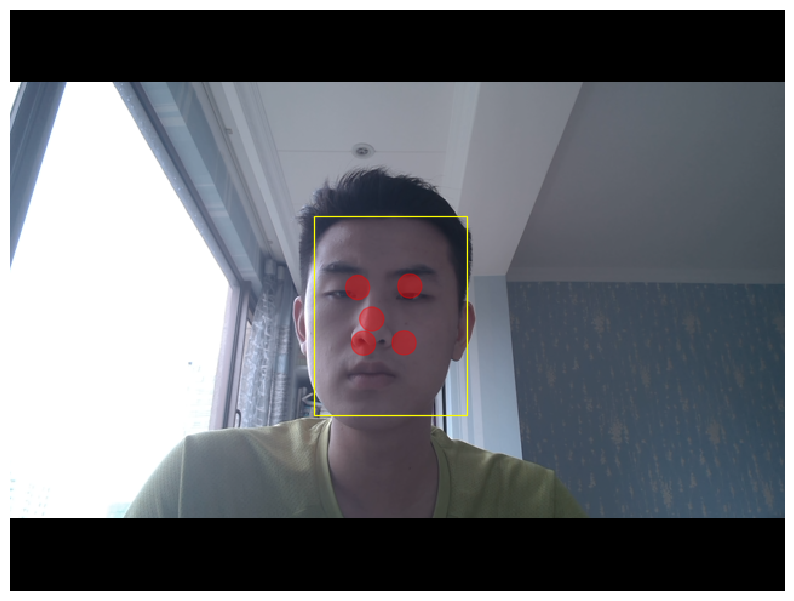

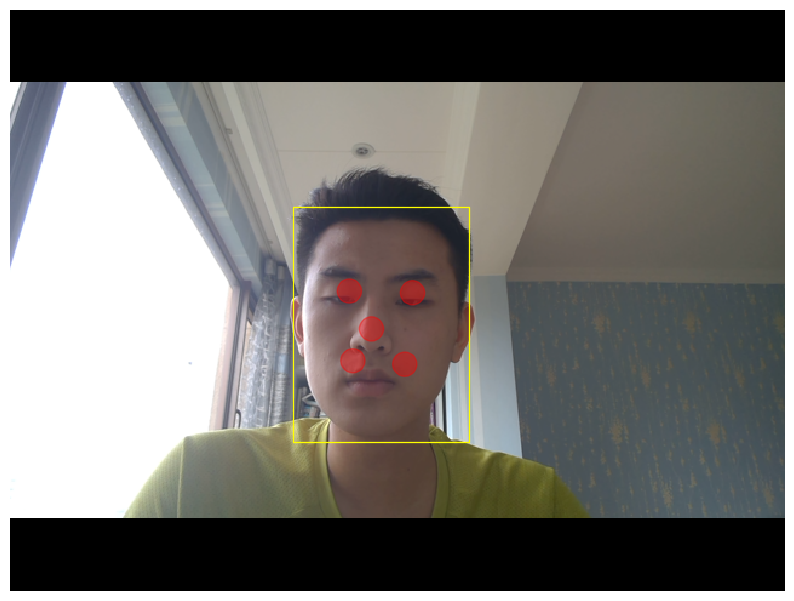

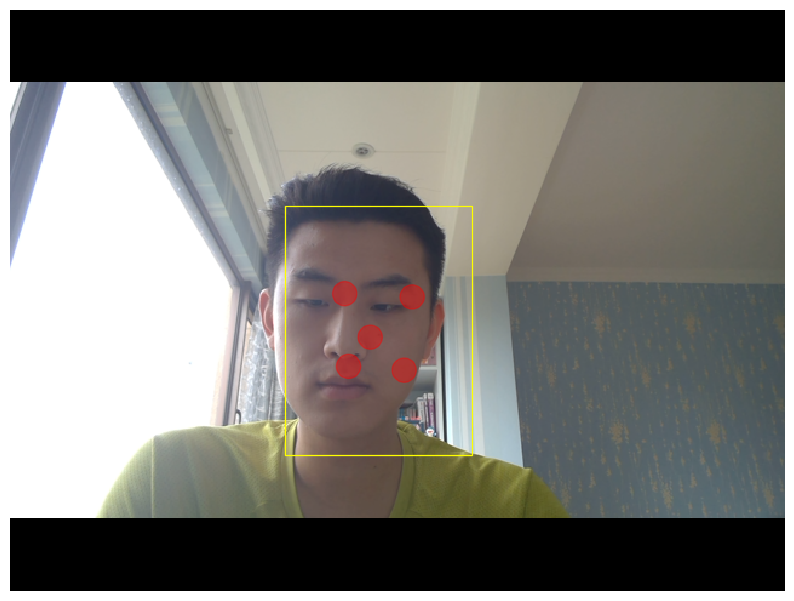

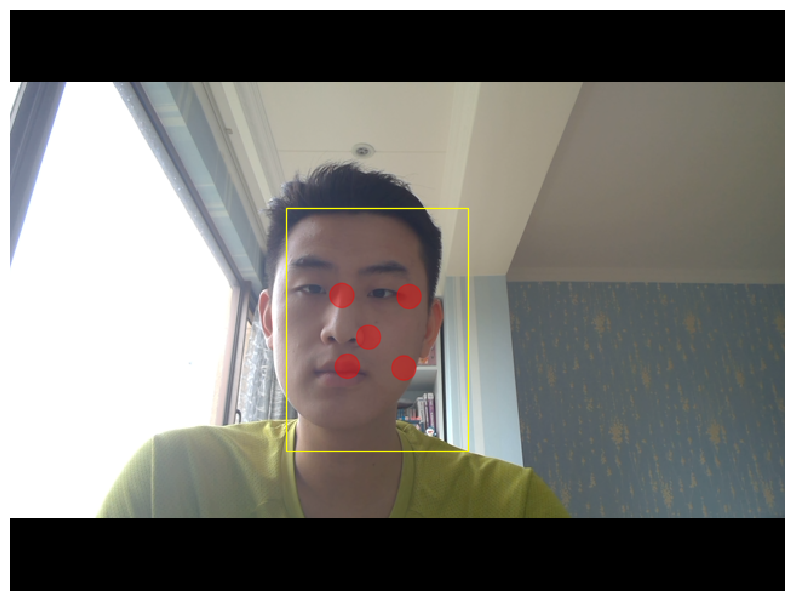

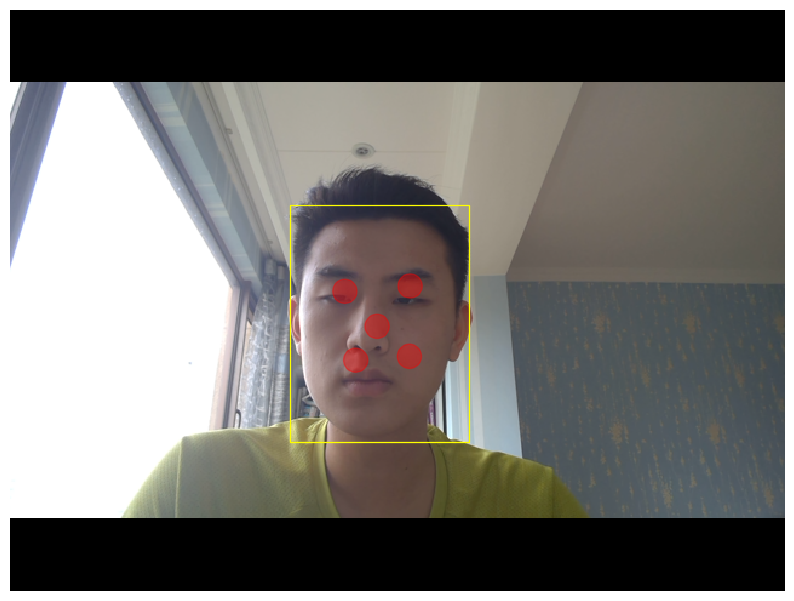

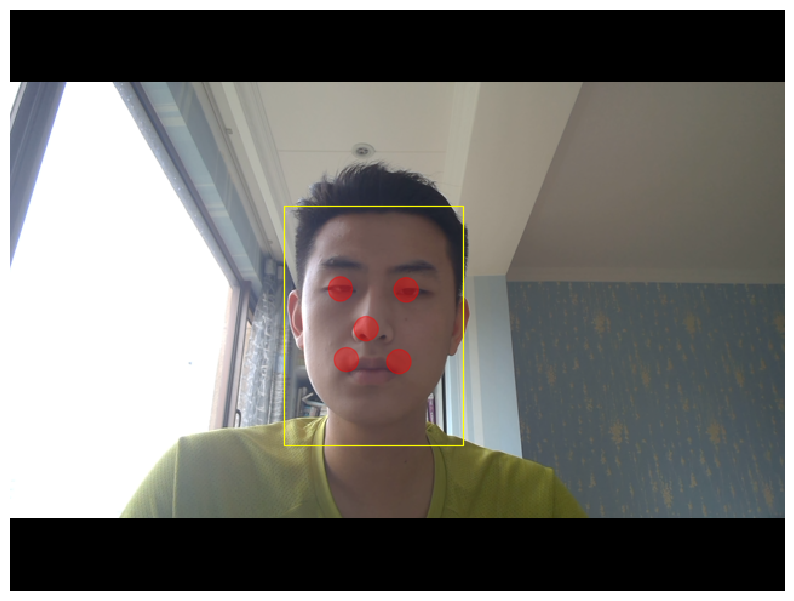

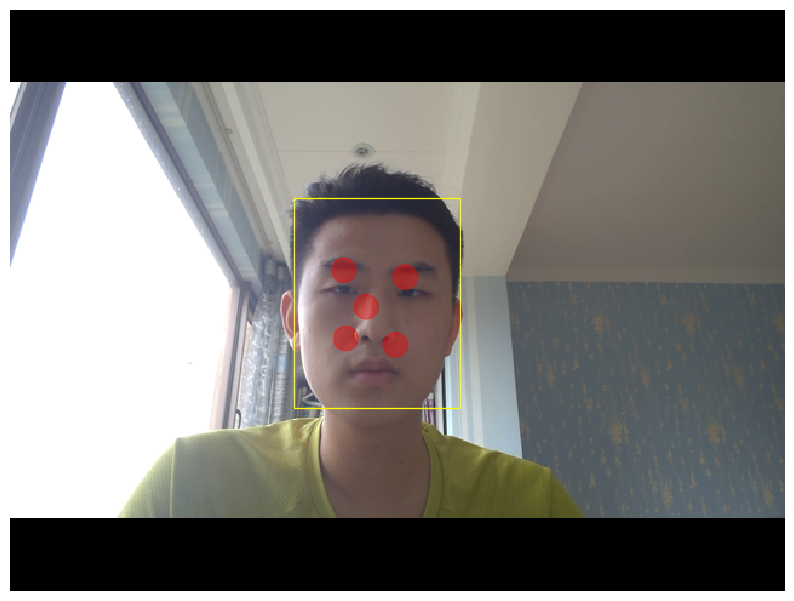

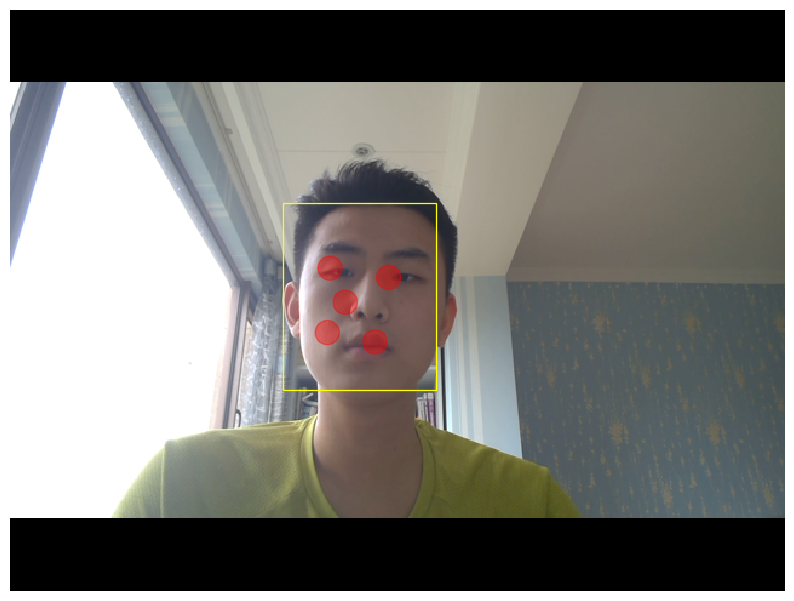

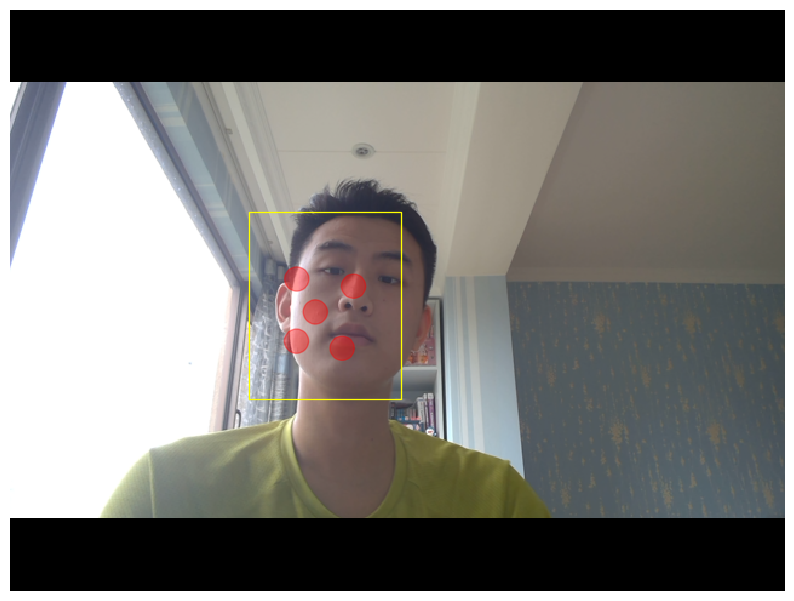

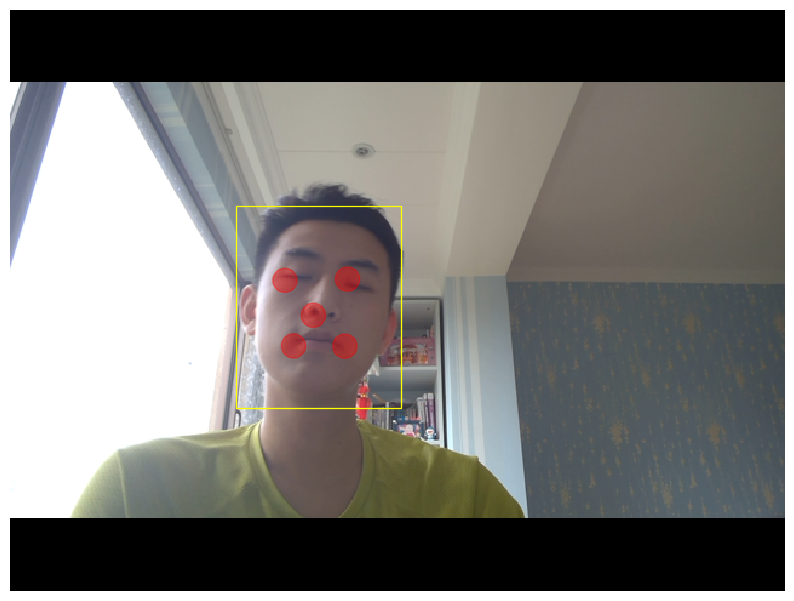

In [8]:
pic_path="output/chuhr2"
images_list = os.listdir(pic_path)
images_list.sort()
for i in range(0,10):
    test(images_list,json_data,i)

## 测试我的model给出的信息

In [35]:
from torch.nn.modules.distance import PairwiseDistance

In [36]:
l2_distance = PairwiseDistance(2)

### embdedings 是一个list 里面的元素也是一个list（128个元素组成的list）
### 要判断那个框内的人是不是同一个人要取出那个特定的embedding

In [37]:
embeddings1=torch.Tensor(json_data[2]["face_embed"])
embeddings2=torch.Tensor(json_data[0]["face_embed"])

In [38]:
embedding1=embeddings1[0]
embedding2=embeddings2[0]

In [39]:
dist= l2_distance(embedding1,embedding2).item()

In [40]:
print(dist)

0.1020428016781807


In [41]:
print( best_distance_threshold)

2.1260780155658745


In [42]:
if dist<best_distance_threshold:
    print("same person")

same person
